In [1]:
# pip installs

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
import statistics
from tqdm import tqdm

from zipfile import ZipFile

from tokenizers import Tokenizer, models, pre_tokenizers, trainers

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Data preprocessing

### here we need to load the data and extract only data with vowels punctuations

In [2]:
import requests
import os
import json
# path to the jason file for the dataset
data_json_path = 'data/books.json'

# Root directory where the downloaded files will be saved
texts_path = 'data/texts'


# Create the directory if it does not exist
if not os.path.exists(texts_path):
    os.makedirs(texts_path)


# Load the json dataset
with open(data_json_path, 'r', encoding='utf-8') as f:
    jason_data = json.load(f)

# download the files and save them in a folder

#### remove\add the comment as needed

In [3]:
# Loop through the json dataset and download the files
for entry in tqdm(jason_data):
    try:
        # Download the text file
        text_url = entry['textFileURL']
        text_local_path = os.path.join(texts_path, entry['fileName'] + '__text.zip')
        text_response = requests.get(text_url)
        with open(text_local_path, 'wb') as f:
            f.write(text_response.content)

            # Unzip the text file
            with ZipFile(text_local_path, 'r') as zipObj:
                zipObj.extractall(os.path.join(texts_path, entry['fileName'] + '__text'))

        # Download the Nikud Meteg file
        nikud_meteg_url = entry['nikudMetegFileURL']
        nikud_meteg_local_path = os.path.join(texts_path, entry['fileName'] + '__nikud_meteg.zip')
        nikud_meteg_response = requests.get(nikud_meteg_url)
        with open(nikud_meteg_local_path, 'wb') as f:
            f.write(nikud_meteg_response.content)

            # Unzip the Nikud Meteg file
            with ZipFile(nikud_meteg_local_path, 'r') as zipObj:
                zipObj.extractall(os.path.join(texts_path, entry['fileName'] + '__nikud_meteg'))
    except Exception as e:
        print(f"Error reading file {entry['fileName']}: {e}")
        continue


# iterate through the texts folder and delete the zip folders
for file in tqdm(os.listdir(texts_path)):
    if file.endswith(".zip"):
        os.remove(os.path.join(texts_path, file))

            


  2%|▏         | 8/402 [00:06<05:04,  1.30it/s]

Error reading file asherlishlomo: File is not a zip file


 23%|██▎       | 91/402 [01:53<06:13,  1.20s/it]

Error reading file divredavidtureizahav1: File is not a zip file


 81%|████████  | 324/402 [07:25<01:50,  1.42s/it]

Error reading file shevetsofer1: File is not a zip file


 96%|█████████▌| 384/402 [08:52<00:21,  1.22s/it]

Error reading file zechutadeavrahamrambam: File is not a zip file


 97%|█████████▋| 391/402 [09:00<00:11,  1.04s/it]

Error reading file einmeirrambam: File is not a zip file


 99%|█████████▊| 396/402 [09:06<00:06,  1.08s/it]

Error reading file igrahramah1: File is not a zip file


 99%|█████████▉| 398/402 [09:08<00:04,  1.01s/it]

Error reading file kappeiaharonrambam: File is not a zip file


 99%|█████████▉| 399/402 [09:09<00:02,  1.19it/s]

Error reading file kappeiaharonshas: File is not a zip file


100%|█████████▉| 400/402 [09:09<00:01,  1.38it/s]

Error reading file kappeiaharontur: File is not a zip file


100%|██████████| 402/402 [09:11<00:00,  1.37s/it]


Error reading file shutmaharsalfandari: File is not a zip file


100%|██████████| 1584/1584 [00:00<00:00, 12854.41it/s]


# get list of clean data

### (1) get list of files that have version of nikud and without nikud
### (2) create author files dictionary
### (3) create list of tuples (path_without_nikud, path_with_nikud)

In [5]:
# Define a method to get the list of author files
def get_author_files():
    """
    This function returns a list of author files that have both text and nikud_meteg files.
    """
    author_files = []
    for file in os.listdir(texts_path):
        if file.endswith("_text"):
            file_name = file.split('__')[0]
            if file_name + '__nikud_meteg' in os.listdir(texts_path):
                author_files.append(file_name)
    return author_files


# Define a method to create the author files dictionary
def create_author_files_dict(author_files):
    """
    This function creates a dictionary of author files with their corresponding text and nikud_meteg files.
    """
    author_files_dict = {}
    for file in author_files:
        author_files_dict[file] = {}
        author_files_dict[file]['text'] = []
        author_files_dict[file]['nikud_meteg'] = []
        for text_file_name in os.listdir(os.path.join(texts_path, file + '__text')):
            author_files_dict[file]['text'].append(text_file_name)
        for nikud_meteg_file_name in os.listdir(os.path.join(texts_path, file + '__nikud_meteg')):
            author_files_dict[file]['nikud_meteg'].append(nikud_meteg_file_name)
    return author_files_dict


# Define a method to create the files list, list of tuples, where each tuple contains the file paths of a text file and its corresponding nikud_meteg file
def create_files_list(author_files_dict):
    """
    This function creates a list of tuples, where each tuple contains the file paths of a text file and its corresponding nikud_meteg file.
    """
    files_list = []
    for file in author_files_dict:
        for i in range(len(author_files_dict[file]['text'])):
            text_file_path = os.path.join(texts_path, file + '__text', author_files_dict[file]['text'][i])
            nikud_meteg_file_path = os.path.join(texts_path, file + '__nikud_meteg', author_files_dict[file]['nikud_meteg'][i])
            files_list.append((text_file_path, nikud_meteg_file_path))
    return files_list


# Call the methods to create the dataset
author_files = get_author_files()
author_files_dict = create_author_files_dict(author_files)
files_tuple_list = create_files_list(author_files_dict)

print(f"Number of authors: {len(author_files)}")
print(f"Number of files: {len(files_tuple_list)}")


Number of authors: 392
Number of files: 54788


# create DataSet class

In [11]:
# Define the dataset class, get iten will return the text and the nikud_meteg
class NikudMetegDataset(Dataset):
    def __init__(self, files_list):
        self.files_list = files_list

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        # Read the text and the nikud_meteg files
        with open(self.files_list[idx][0], 'r', encoding='utf-8') as f:
            text = f.read()
        with open(self.files_list[idx][1], 'r', encoding='utf-8') as f:
            nikud_meteg = f.read()
        return text, nikud_meteg



# split the data into train validation and test
train_files_list, test_files_list = train_test_split(files_tuple_list, test_size=0.1, random_state=42)
train_files_list, val_files_list = train_test_split(train_files_list, test_size=0.2, random_state=42)

# Create a dataset object
train_dataset = NikudMetegDataset(train_files_list)
val_dataset = NikudMetegDataset(val_files_list)
test_dataset = NikudMetegDataset(test_files_list)

print(f"Number of train files: {len(train_dataset)}")
print(f"Number of validation files: {len(val_dataset)}")
print(f"Number of test files: {len(test_dataset)}")


Number of train files: 39447
Number of validation files: 9862
Number of test files: 5479


# performe EDAs on the data

Train Dataset EDA:


100%|██████████| 39447/39447 [04:34<00:00, 143.66it/s]


Number of samples in the dataset: 39447
Mean text length: 5387.45 (std: 1730.17)
Mean nikud_meteg length: 8615.81 (std: 2768.68)


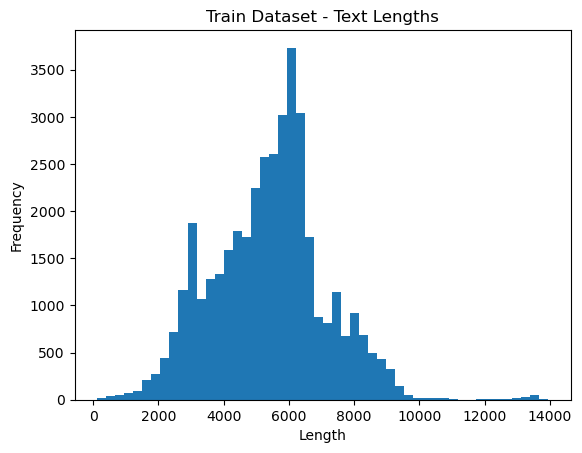

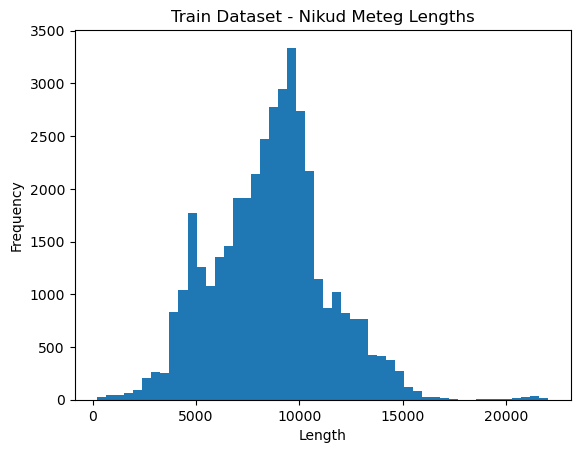

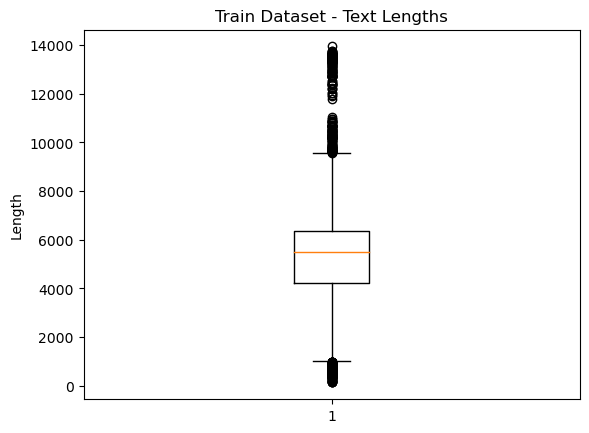

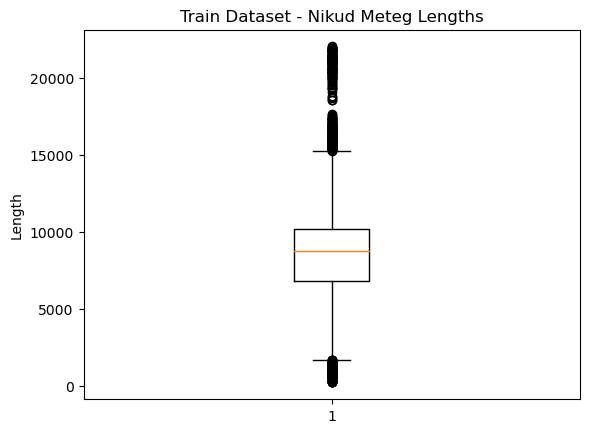

Validation Dataset EDA:


100%|██████████| 9862/9862 [01:16<00:00, 129.76it/s]


Number of samples in the dataset: 9862
Mean text length: 5375.47 (std: 1740.97)
Mean nikud_meteg length: 8595.80 (std: 2785.48)


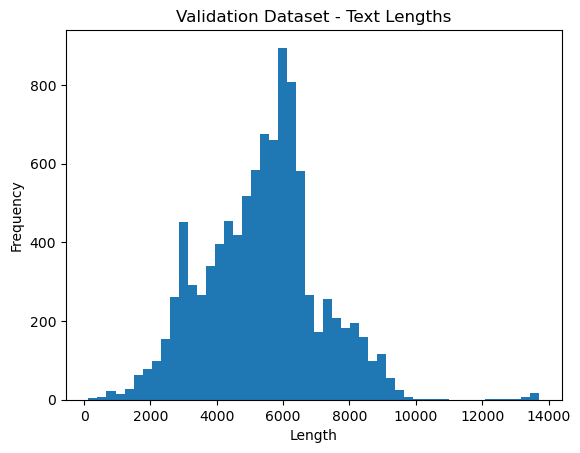

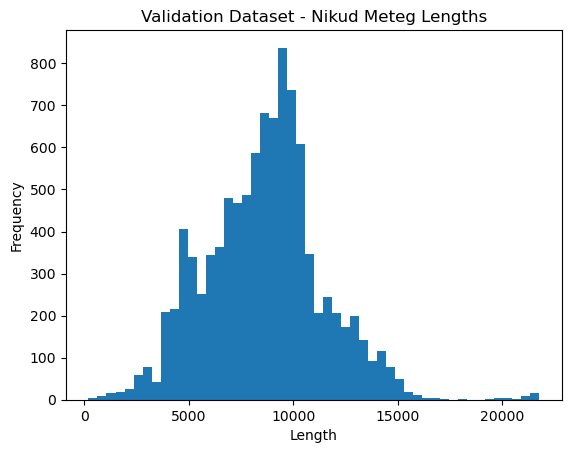

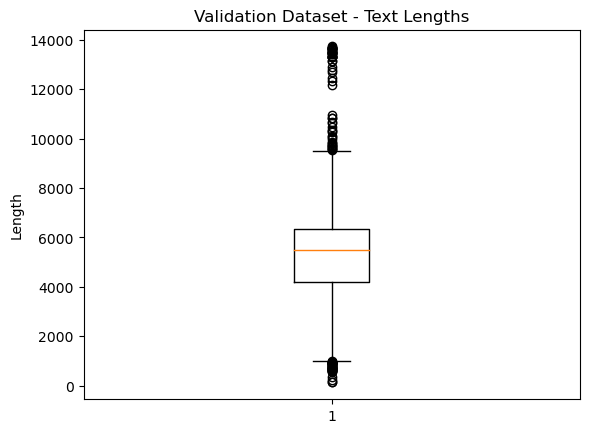

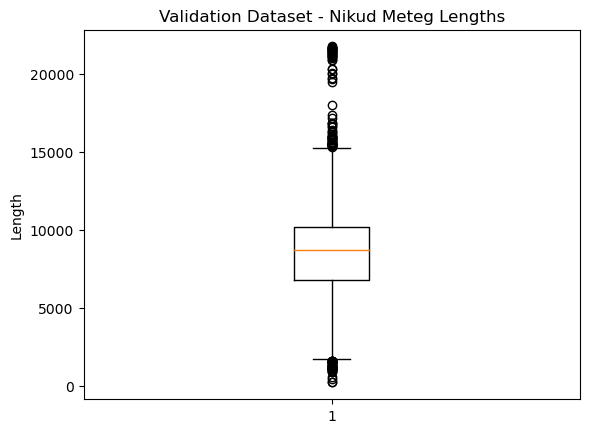

Test Dataset EDA:


100%|██████████| 5479/5479 [00:50<00:00, 109.31it/s]


Number of samples in the dataset: 5479
Mean text length: 5336.23 (std: 1729.75)
Mean nikud_meteg length: 8533.81 (std: 2763.55)


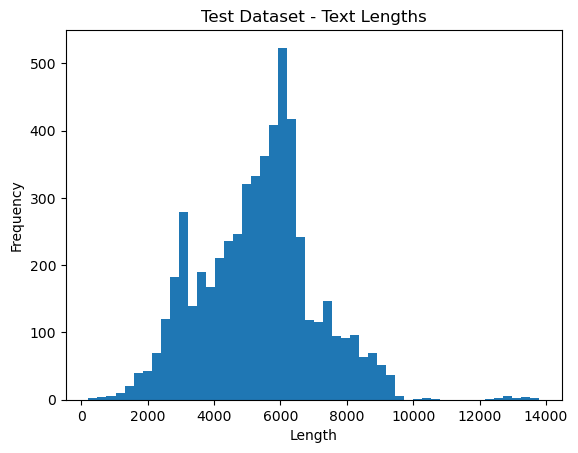

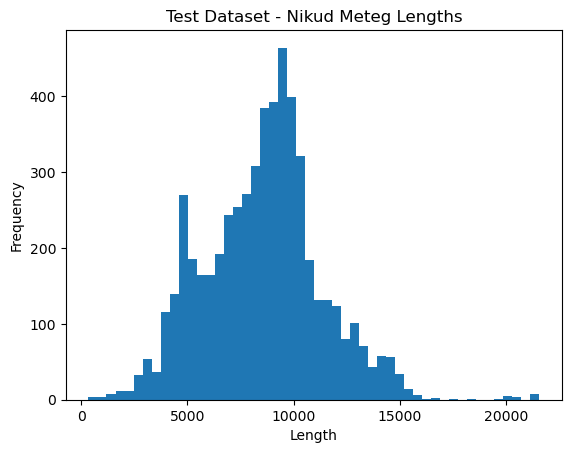

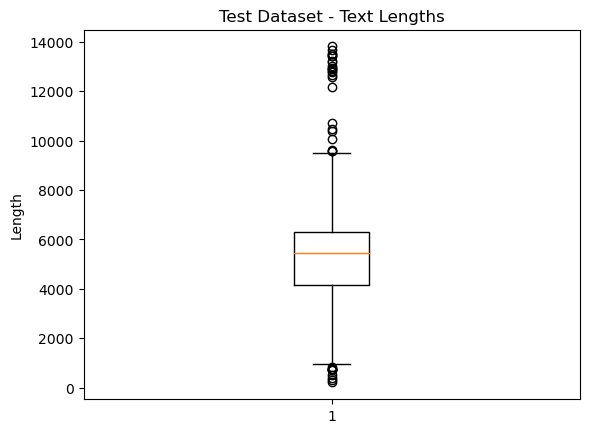

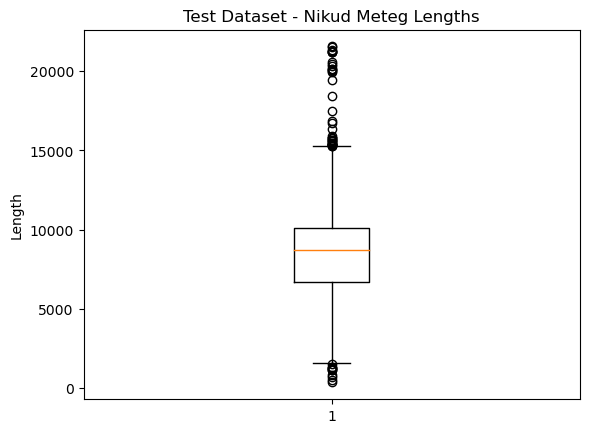

In [13]:
def perform_eda(dataset, title):
    # Get the text and nikud_meteg data from the dataset
    texts = []
    nikud_metegs = []
    for i in tqdm(range(len(dataset))):
        text, nikud_meteg = dataset[i]
        texts.append(text)
        nikud_metegs.append(nikud_meteg)

    # Calculate the length of the texts and nikud_metegs
    text_lengths = [len(text) for text in texts]
    nikud_meteg_lengths = [len(nikud_meteg) for nikud_meteg in nikud_metegs]

    # Calculate the mean and standard deviation of the text and nikud_meteg lengths
    text_mean_length = sum(text_lengths) / len(text_lengths)
    text_std_length = statistics.stdev(text_lengths)
    nikud_meteg_mean_length = sum(nikud_meteg_lengths) / len(nikud_meteg_lengths)
    nikud_meteg_std_length = statistics.stdev(nikud_meteg_lengths)

    # Print the results
    print(f"Number of samples in the dataset: {len(dataset)}")
    print(f"Mean text length: {text_mean_length:.2f} (std: {text_std_length:.2f})")
    print(f"Mean nikud_meteg length: {nikud_meteg_mean_length:.2f} (std: {nikud_meteg_std_length:.2f})")

    # Create histograms of the text and nikud_meteg lengths
    plt.hist(text_lengths, bins=50)
    plt.title(f"{title} - Text Lengths")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

    plt.hist(nikud_meteg_lengths, bins=50)
    plt.title(f"{title} - Nikud Meteg Lengths")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

    # Create a boxplot of the text and nikud_meteg lengths
    plt.boxplot(text_lengths)
    plt.title(f"{title} - Text Lengths")
    plt.ylabel("Length")
    plt.show()

    plt.boxplot(nikud_meteg_lengths)
    plt.title(f"{title} - Nikud Meteg Lengths")
    plt.ylabel("Length")
    plt.show()


# Perform EDA on the train, validation and test datasets
print("Train Dataset EDA:")
perform_eda(train_dataset, "Train Dataset")
print("Validation Dataset EDA:")
perform_eda(val_dataset, "Validation Dataset")
print("Test Dataset EDA:")
perform_eda(test_dataset, "Test Dataset")


# dataloader and tokenizer

In [18]:
# Define dataloader parameters
batch_size = 1

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# test the dataloader
for text, nikud_meteg in train_dataloader:
    # print as list of chars
    print((text[0]))
    print((nikud_meteg[0]))
    break


דלא עשו עדים שליחותם יכתבו גט אחר אבל יכולים אנו לחלק דאפשר דתפואתה הוא ג"כ שם שאנו קורין לנשים אחרות או לשון תפואתה יש לו משמעו' אחר מנפיאתא אבל הכא דקיראנה וכיראנה שם א' הוא שאינ' קורין לא' קיראנ' ולא' כיראנ'וגם אין משמעו' אחר בכיראנ' ממשמעו' קיראנ' כי הכל ל' אדנות הוא ולא הוו שינוי שם והגט כשר ומפני שלא חלקו חילוק זה המפרשי' ז"ל וכולם כתבו סתם נפואית' תפואותה לא עשו עדים שליחותם וכו' לא אסמוך על חילוק זה לבדו אלא שיש חילוק והפרש בין נפואיתא לתפואיתא בכתיבה ובקריאה אבל בין קיראנה לכיראנה אין חילוק והפרש ניכר לנו בקריא' ואפי' יש הפרש בכתיב' אין לחוש כי העיקר הוא קריאת השם ולא הוי שינוי כלל וזה השם של קיראנה יש מי שקורא אותה קיראנ' שנרא' בקריאה שהוא בקוף ויש מי שקורא אותה כיראנה שנראה בקריאה שהוא בכף ויש מי שקורא אותה ג'יראנה ברפה הגימל שנראה מקריאתה בגימל רפוייה וכן בכתיב' יש מי שכותב אותו בין בקוף או בכף או בגימל וכיון שההפרש הוא מעט שהנעת ג' אותיות אלו הוא קרוב זה לזה והן ממוצא אחד אין לחוש כי הכל משמעו' ענין אחד הוא אם כיראנה או קיראנ' או ג'יראנה כי כולם שם א' אלא שזה אומר בדגשו' ו

# Define the two models (one with look-ahead, one without)

### train the two models

### Evaluate the models

In [17]:
class PunctuationPredictionModelWithLookahead(nn.Module):
    def __init__(self, num_words, num_punctuations, embedding_dim=256, num_heads=8, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.transformer = nn.Transformer(embedding_dim, num_heads, num_layers)
        self.fc = nn.Linear(embedding_dim, num_punctuations)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return x


class PunctuationPredictionModelWithoutLookahead(nn.Module):
    def __init__(self, num_words, num_punctuations, embedding_dim=256, num_heads=8, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.transformer = nn.Transformer(embedding_dim, num_heads, num_layers)
        self.fc = nn.Linear(embedding_dim, num_punctuations)

    def forward(self, x):
        x = self.embedding(x)
        mask = self._generate_future_mask(x.size(0)).to(x.device)
        x = self.transformer(x, src_mask=mask)
        x = self.fc(x)
        return x

    def _generate_future_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


# Define the dual model class, it will be composed of two models.
#### whenever there is a disagreement between the two models, the model will add nikud using the lookahead model

## Evaluation of the dual model